In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, make_scorer, f1_score, roc_auc_score, det_curve
from sklearn import preprocessing
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, PredefinedSplit, GridSearchCV
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
import json

%matplotlib inline

In [2]:
def concat_dataframes(path, df_type):
    dfs_list = []
    dfs_rows_len_list = []
    
    for user in os.listdir(path):
        for file in os.listdir(os.path.join(path, user)):
            if file.find(df_type) != -1:
                df = pd.read_csv(os.path.join(path, user, file))
                
                if df_type != 'broadcasts':
                    df = df.drop(["timestamp"], axis=1)
#                 df = (df - df.min()) / (df.max() - df.min())
                
                df["user"] = int(user.split('_')[1])
                
                dfs_list.append(df)
    
    return pd.concat(dfs_list, ignore_index=True)


def drop_bad_rows(df, z = 3):
    bad_rows = set()
    for col in df.columns:
        if col != "user":
            for user in df.user.unique():
                for x in list(df.loc[df.user == user, :][np.abs(stats.zscore(df.loc[df.user == user, col])) > z].index):
                    bad_rows.add(x)

            for x in list(df[col][np.abs(stats.zscore(df[col])) > z].index):
                bad_rows.add(x)

    df = df.drop(list(bad_rows), axis=0)

    return df


def drop_bad_cols(df, z = 3, allowed_proportion = 0.1):
    bad_cols = set()
    for col in df.columns:
        if col != "user":
            if df[df[col] != df[col].mean()].shape[0] < allowed_proportion * df.shape[0]:
                bad_cols.add(col)

            for user in df.user.unique():
                if df.loc[df.user == user, :][df.loc[df.user == user, col] != df.loc[df.user == user, col].mean()].shape[0] < allowed_proportion * df.loc[df.user == user, :].shape[0]:
                    bad_cols.add(col)

                elif np.sum(np.abs(stats.zscore(df.loc[df.user == user, col])) < z) < (1 - allowed_proportion) * df.loc[df.user == user, col].shape[0]:
                    bad_cols.add(col)

    df = df.drop(bad_cols, axis=1)
    return df, list(bad_cols)
    
    
def extract_delayed_user(df, user_label):
    df_user = df[df["user"] == user_label]
    df = df[df["user"] != user_label]
    return df_user, df


def split_users_into_two_classes(df, valid_user_label):
    df.loc[df["user"] != valid_user_label, "user"] = 0
    df.loc[df["user"] == valid_user_label, "user"] = 1
    return df  


def get_cv_split(X, y, group_labels, valid_user_label):
    predefined_split_array = np.zeros(group_labels.shape[0])
    i = 0
    test_array = [x for x in range(group_labels.shape[0])]
    for test, _ in LeaveOneGroupOut().split(X, y, group_labels):
        diff = np.setdiff1d(test_array, test)
        if np.all(group_labels[diff[0] : diff[-1]] == valid_user_label) is np.bool_(True):
            for sample in diff:
                predefined_split_array[sample] = -1
        else:
            for sample in diff:
                predefined_split_array[sample] = i
            i += 1
    return predefined_split_array


def generate_train_dataset(df, user, ex_user, is_SVM = False):
    df_ = df.copy()

    df_for_test = []

    df__ = df_[df_.labels == ex_user].copy()
    df_for_test.append(df__)
    df_ = df_.drop(df__.index, axis=0)

    for user_ in df_.labels.unique():
        if user_ != ex_user:
            test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
            df__ = df_[df_.labels == user_].sample(test_size).copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

    df_ = split_users_into_two_classes(df_.copy(), user)
          
    if is_SVM:    
        df_.loc[df_.user == 0, 'user'] = -1

    df_ = df_.drop("labels", axis=1)

    dataset = df_.to_numpy().copy()
    np.random.shuffle(dataset)

    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    return X, y, df_for_test


def generate_test_dataset(df_list, user, ex_user, is_SVM = False):
    test_df = pd.concat(df_list)

    valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
    ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
    others_in_test_count = [test_df[test_df.labels == x].shape[0]
                            for x in test_df.labels.unique() if x != user and x != ex_user]

    others_test_count = sum(others_in_test_count)
    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
    if others_test_count <= min(valid_user_in_test_count, ex_user_in_test_count):
        part_size = others_test_count    
        
    new_df_parts = []    

    new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
    new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())
    new_df_parts.append(test_df[~test_df.labels.isin([user, ex_user])].sample(part_size).copy())
    
    test_df = pd.concat(new_df_parts)
    
    test_df.loc[test_df.labels == user, "user"] = 1
    if is_SVM:
        test_df.loc[test_df.labels != user, "user"] = -1
    else:
        test_df.loc[test_df.labels != user, "user"] = 0

    print("True: ", test_df[test_df.user == 1].shape)
    print("Shape: ", test_df.shape)
    for x in test_df.labels.unique():
        print("Count ", x, ": ", test_df[test_df.labels == x].shape)

    test_df = test_df.drop("labels", axis=1)

    test_dataset = test_df.to_numpy().copy()
    X_test = test_dataset[:, :-1].copy()
    y_test = test_dataset[:, -1].copy()

    return X_test, y_test


def prepare_dataset(df, user, is_SVM=False):
    df_ = split_users_into_two_classes(df.copy(), user)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    if is_SVM:
        df_.loc[df_.user == 0, 'user'] = -1
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    return X, y, group_labels


def create_file_for_results(data_type):
    res_folder = '.\\_results'
    if os.path.exists(res_folder) is False:
        os.makedirs(res_folder)
    
    file = os.path.join(res_folder, data_type + '_results.json')
    if os.path.exists(file) is False:
        with open(file, 'w') as f:
            json.dump({'stub': None}, f)
        
    return file    


def update_file_with_results(file_path, results_dict):
    import collections.abc

    def update(d, u):
        for k, v in u.items():
            if isinstance(v, collections.abc.Mapping):
                d[k] = update(d.get(k, {}), v)
            else:
                d[k] = v
        return d
    
    with open(file_path, 'r') as f:
        res = json.load(f)
    
    res = update(res, results_dict)
    
    with open(file_path, 'w') as f:
        json.dump(res, f, sort_keys=True, indent=2)
        
        
def get_dict_with_results(json_path):
    with open(json_path, 'r') as f:
        res = json.load(f)
    return res    


def get_dataframe(path, data_type, window_type, window_size):
    return concat_dataframes(os.path.join(path, window_type, window_size), data_type)


def drop_corr_columns(df, corr_coef):
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    corr_cols = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > corr_coef) and column != "user"]
    return df.drop(corr_cols, axis=1), corr_cols


def process_train_df(df, features, corr = 0.7, z = 3, prop = 0.1): 
    df = df.drop(df.columns.difference(features), axis=1)
    df = df.dropna(how='all')
    df = df.fillna(0)
    
    if 'count_mean' in df.columns:
        df = df[df.count_mean != 0]
    
    df = drop_bad_rows(df, z)
    df, dropped_cols_1 = drop_bad_cols(df, z, prop)
    df, dropped_cols_2 = drop_corr_columns(df, corr)
    
    return df, dropped_cols_1 + dropped_cols_2

In [29]:
DATA_PATH = '..\\scripts\\_features_all'

DATA_TYPE = "location"

WINDOW_TYPE = "rolling"
WINDOW_SIZE = "120s"

In [30]:
df = get_dataframe(DATA_PATH, DATA_TYPE, WINDOW_TYPE, WINDOW_SIZE)
features = df.columns.to_list()

In [6]:
df, _ = process_train_df(df, features)

D:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


In [22]:
features = df.columns.to_list()

In [31]:
def drop_corr_columns(df, corr_coef):
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    corr_cols = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > corr_coef) and column != "user"]
    return df.drop(corr_cols, axis=1), corr_cols

In [32]:
df, _ = drop_corr_columns(df, 0.7)

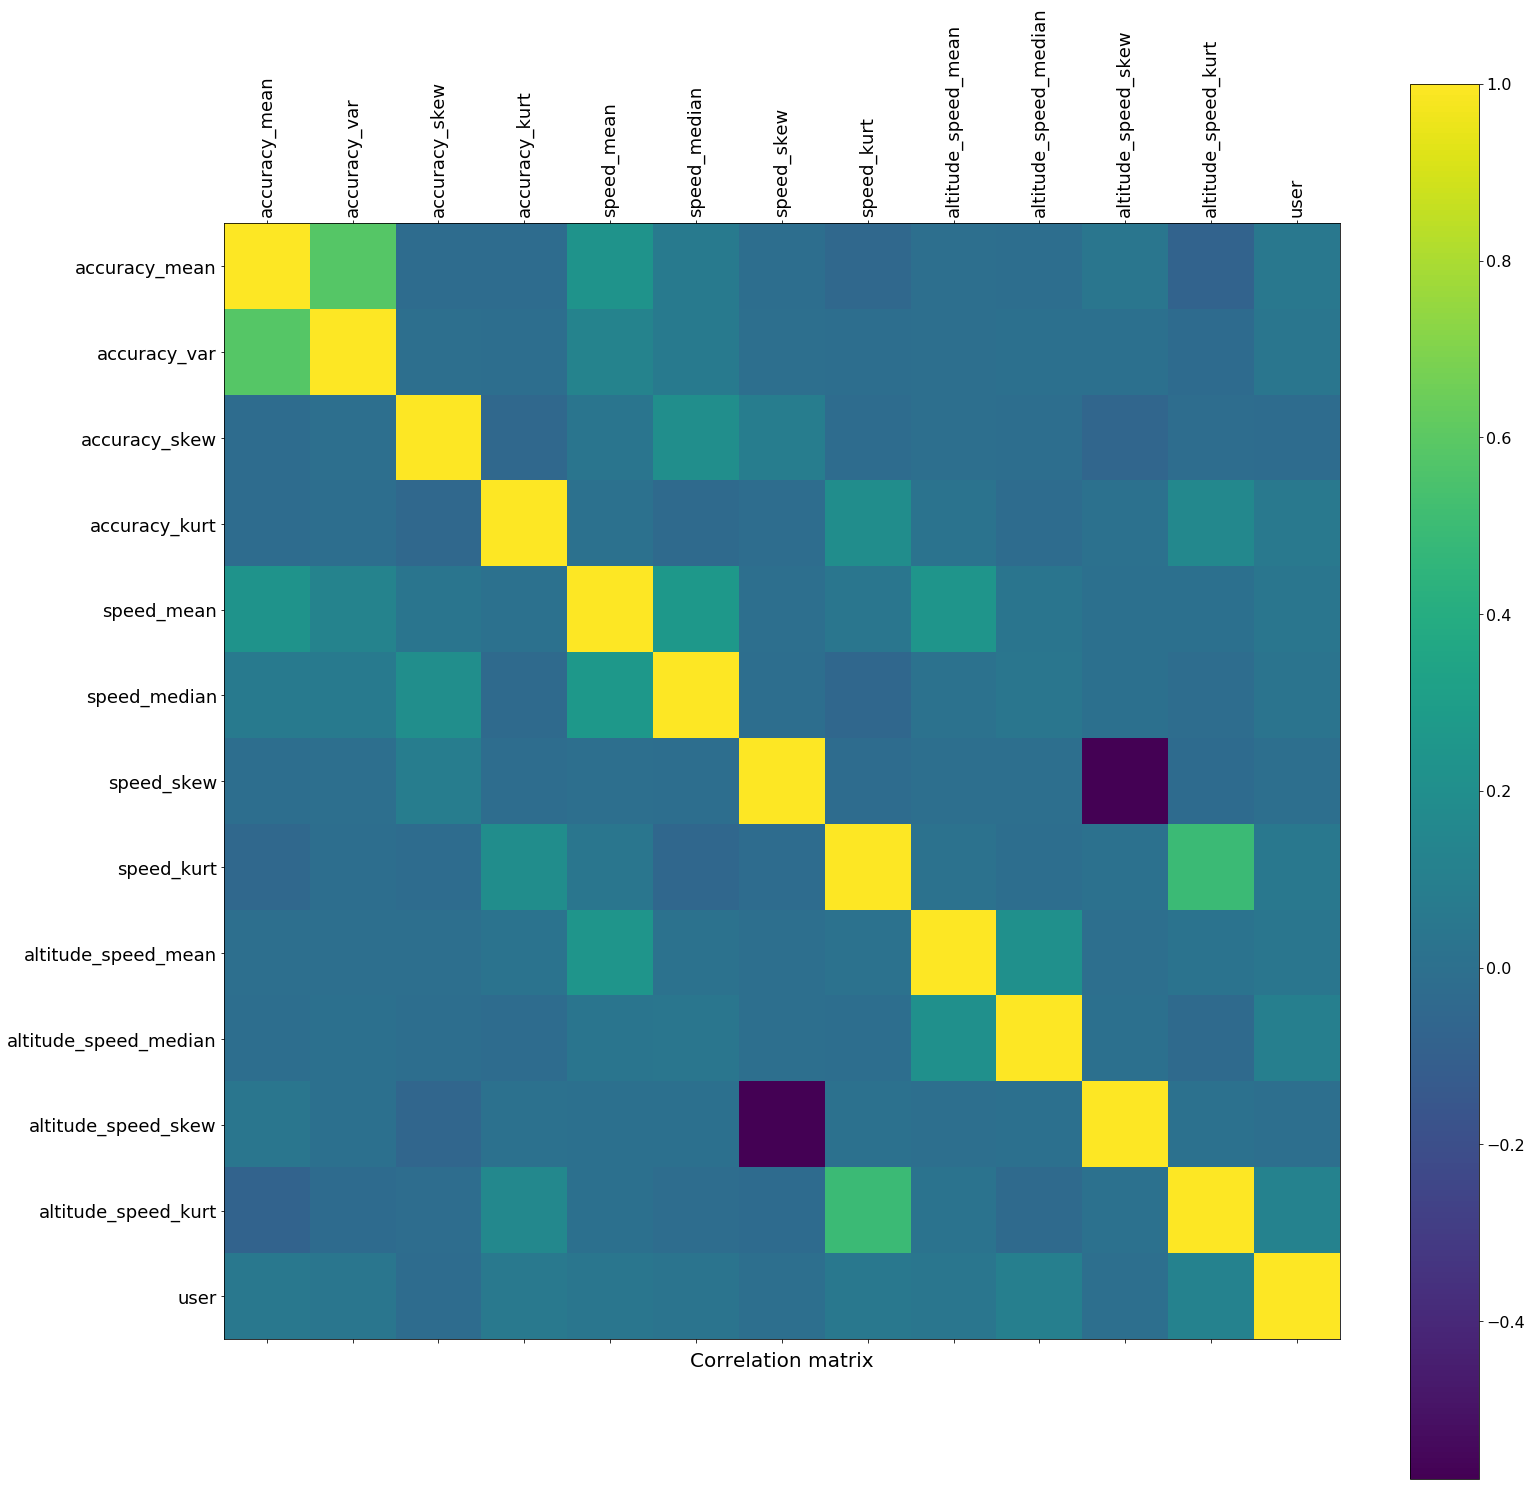

In [34]:
fig = plt.figure(figsize=(25, 25))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=18, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title("Correlation matrix", fontsize=20, y=-0.03)
plt.savefig("corr_after.png")

In [12]:
features

['count_mean',
 'count_var',
 'count_median',
 'count_skew',
 'count_kurt',
 'le_connectable_mean',
 'le_connectable_var',
 'le_connectable_median',
 'le_connectable_skew',
 'le_connectable_kurt',
 'le_level_mean',
 'le_level_var',
 'le_level_median',
 'le_level_skew',
 'le_level_kurt',
 'occured_devices_count_mean_mean',
 'occured_devices_count_mean_mad',
 'occured_devices_count_mean_skew',
 'occured_devices_count_median_mean',
 'occured_devices_count_median_mad',
 'occured_devices_count_median_skew',
 'occured_devices_count_var_mean',
 'occured_devices_count_var_mad',
 'occured_devices_count_var_skew',
 'disappeared_devices_count_mean_mean',
 'disappeared_devices_count_mean_mad',
 'disappeared_devices_count_mean_skew',
 'disappeared_devices_count_median_mean',
 'disappeared_devices_count_median_mad',
 'disappeared_devices_count_median_skew',
 'disappeared_devices_count_var_mean',
 'disappeared_devices_count_var_mad',
 'disappeared_devices_count_var_skew',
 'jaccard_index_mean_mean',


In [15]:
df

,count_mean,count_var,count_median,count_skew,count_kurt,le_connectable_mean,le_connectable_var,le_connectable_median,le_connectable_skew,le_connectable_kurt,...,count_speed_mean_mean,count_speed_mean_mad,count_speed_mean_skew,count_speed_median_mean,count_speed_median_mad,count_speed_median_skew,count_speed_var_mean,count_speed_var_mad,count_speed_var_skew,user
0,0.375000,0.401042,0.0,1.461165,0.897622,0.416667,0.243056,0.0,0.338062,-1.885714,...,-6.944444e-03,0.589699,0.876952,0.187500,0.640625,0.552044,0.437500,0.322917,1.088454e+00,1
1,0.458333,0.498264,0.0,1.213882,0.034892,0.416667,0.243056,0.0,0.338062,-1.885714,...,6.944444e-02,0.648148,0.679686,0.291667,0.722222,0.463862,0.472222,0.375000,9.310670e-01,1
2,0.458333,0.498264,0.0,1.213882,0.034892,0.416667,0.243056,0.0,0.338062,-1.885714,...,5.555556e-02,0.657407,0.679043,0.291667,0.722222,0.463862,0.513889,0.422454,7.423612e-01,1
3,0.458333,0.498264,0.0,1.213882,0.034892,0.416667,0.243056,0.0,0.338062,-1.885714,...,2.777778e-02,0.675926,0.720022,0.291667,0.722222,0.463862,0.569444,0.453704,5.733611e-01,1
4,0.458333,0.498264,0.0,1.213882,0.034892,0.416667,0.243056,0.0,0.338062,-1.885714,...,9.251859e-18,0.694444,0.765466,0.291667,0.722222,0.463862,0.625000,0.475694,4.171340e-01,1
5,0.458333,0.498264,0.0,1.213882,0.034892,0.416667,0.243056,0.0,0.338062,-1.885714,...,9.251859e-18,0.694444,0.765466,0.291667,0.722222,0.463862,0.625000,0.475694,4.171340e-01,1
6,0.458333,0.498264,0.0,1.213882,0.034892,0.375000,0.234375,0.0,0.516398,-1.733333,...,9.251859e-18,0.694444,0.765466,0.291667,0.722222,0.463862,0.625000,0.475694,4.171340e-01,1
7,0.458333,0.498264,0.0,1.213882,0.034892,0.333333,0.222222,0.0,0.707107,-1.500000,...,1.387779e-17,0.694444,0.765466,0.291667,0.722222,0.463862,0.625000,0.475694,4.171340e-01,1
8,0.416667,0.493056,0.0,1.380678,0.398730,0.291667,0.206597,0.0,0.916698,-1.159664,...,-4.166667e-02,0.670139,0.921804,0.250000,0.687500,0.600278,0.625000,0.475694,4.171340e-01,1
9,0.416667,0.493056,0.0,1.380678,0.398730,0.250000,0.187500,0.0,1.154701,-0.666667,...,-2.777778e-02,0.659722,0.915714,0.291667,0.663194,0.671058,0.625000,0.475694,4.171340e-01,1


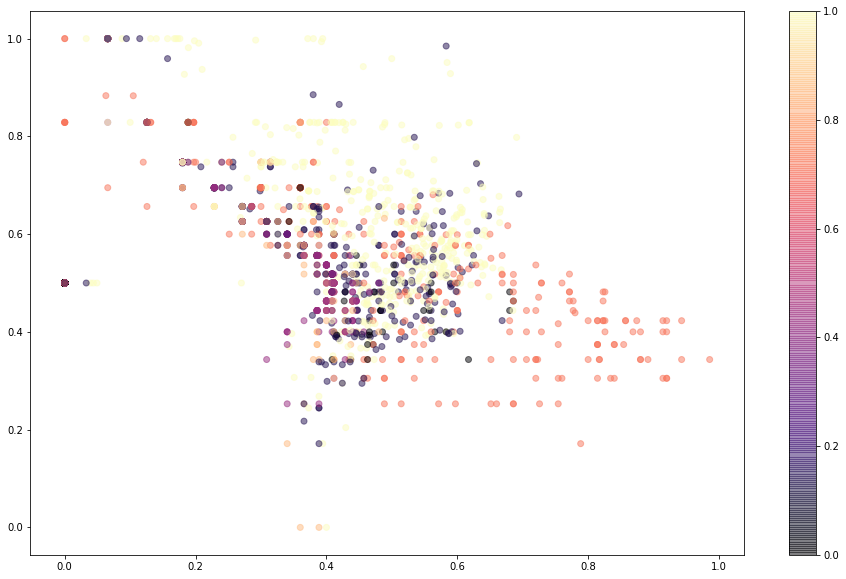

In [19]:
sample = df.sample(50000)
plt.figure(figsize=(16, 10))
plt.scatter(x=sample['disappeared_devices_count_mean_mad'], y=sample['jaccard_index_var_skew'], alpha=0.5, c=sample.user, cmap='magma')
plt.colorbar()
plt.show()

In [17]:
df = (df - df.min()) / (df.max() - df.min())

In [ ]:
# fig = plt.figure(figsize=(20, 25))
# plt.matshow(df.corr(), fignum=fig.number)
# plt.xticks(range(df.shape[1]), df.columns, fontsize=18, rotation=90)
# plt.yticks(range(df.shape[1]), df.columns, fontsize=18)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=16)
# plt.title("Correlation matrix", fontsize=20, y=-0.03)

In [ ]:
# sample = df.sample(1000)
# plt.figure(figsize=(16, 10))
# plt.scatter(x=sample['conn_level_mean'], y=sample['count_var'], alpha=0.5, c=sample.user, cmap='magma')
# plt.colorbar()
# plt.show()

In [ ]:
# for user in df.user.unique():
#     for valid_user in df.user.unique():
#         if user != valid_user:
#             print('---------------------------------------------------------------------------')
#             print('Valid user: ', valid_user, 'Extracted user: ', user)
#             print('---------------------------------------------------------------------------')
#             df1, df_ = extract_delayed_user(df.copy(), user)
#             df1['user'] = 0
#             df_ = split_users_into_two_classes(df_.copy(), valid_user)
#             df_ = resample(df_)

#             dataset = df_.to_numpy()
#             X = dataset[:, :-1]
#             y = dataset[:, -1]

#             X_test = df1.to_numpy()[:, :-1]
#             y_test = df1.to_numpy()[:, -1]
            
#             model = CatBoostClassifier(iterations=100, depth=6, loss_function='Logloss')
#             model.fit(X, y, verbose=False)

#             preds_class = model.predict(X_test)
#             print('Accuracy: ', accuracy_score(preds_class, y_test))

#             sum_ = 0
#             imp = [ (x, i) for x, i in zip(model.feature_importances_, range(len(model.feature_importances_)) )]
#             sorted_ = sorted(imp, key=lambda tup: tup[0])
#             for i in range(len(sorted_)):
#                 if sorted_[i][0] > 5:
#                     print(sorted_[i][1], ': ', df_.columns[sorted_[i][1]], ' - ', sorted_[i][0])

#             print('---------------------------------------------------------------------------')
#             print('---------------------------------------------------------------------------')

In [ ]:
# for d in [VALIDATION_CATBOOST_BIG_DICT, VALIDATION_RFC_BIG_DICT, \
#           VALIDATION_SVC_BIG_DICT, VALIDATION_LR_BIG_DICT]:
    
#     for user, res in d.items():
#         print("Valid User: ", user)
#         print("--------------------------------------------------------------------------------")
#         means_acc = []
#         means_prec = []
#         means_rec = []
#         means_roc = []
#         means_f1 = []
        
#         for ex_user, ex_res in res.items():
#             print('Ex user: ', ex_user)
#             print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

#             y_true = ex_res['y_test']
#             y_pred = ex_res['y_predict']
#             if len(ex_res['y_proba'].shape) > 1 and ex_res['y_proba'].shape[1] > 1:
#                 y_proba = ex_res['y_proba'][:, 1]
#             else:
#                 y_proba = ex_res['y_proba']
                
#             acc = accuracy_score(y_true, y_pred)
#             prec = precision_score(y_true, y_pred)
#             rec = recall_score(y_true, y_pred)
#             f1 = f1_score(y_true, y_pred)
            
#             means_acc.append(acc)
#             means_prec.append(prec)
#             means_rec.append(rec)
#             means_f1.append(f1)

#             print('Accuracy: ', acc)
#             print('Precision: ', prec)
#             print('Recall: ', rec)
#             try:
#                 roc = roc_auc_score(y_true, y_proba)
#                 means_roc.append(roc)
#                 print('ROC-AUC: ', roc)
#             except Exception as e:
#                 print('ROC-AUC: skip')
#             print('F1: ', f1)
#             print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            
#         print('Mean accuracy: ', sum(means_acc) / len(means_acc))
#         print('mean Precision: ', sum(means_prec) / len(means_prec))
#         print('mean Recall: ', sum(means_rec) / len(means_rec))
#         if len(means_roc) > 0:
#             print('mean ROC-AUC: ', sum(means_roc) / len(means_roc))
#         print('mean F1: ', sum(means_f1) / len(means_f1))

#         print("--------------------------------------------------------------------------------")

In [ ]:
# gs_df_parts = []
# for user in df.labels.unique():
#     new_df = df[df.labels == user].sample(int(df[df.labels == user].shape[0] * 0.2)).copy()
#     gs_df_parts.append(new_df)

# df = pd.concat(gs_df_parts)

In [ ]:
# sample = df.sample(10000)

# fig, ax = plt.subplots(figsize=(12, 9))

# scatter = ax.scatter(x=sample['disappeared_devices_count_mean_mad'], y=sample['jaccard_index_var_skew'], \
#                      alpha=0.5, c=sample.user, cmap='plasma')

# # produce a legend with the unique colors from the scatter
# plt.rcParams['legend.title_fontsize'] = 'x-large'
# legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Users", fontsize=14)
# ax.add_artist(legend1)

# plt.xlabel('MAD среднего числа исчезнувших устройств', fontsize=12)
# plt.ylabel('Skew дисперсии расстояния Жаккара', fontsize=12)

# plt.savefig('.\\after.png', dpi=500)
# plt.show()

In [ ]:
# C = 1
# kernel = 'rbf'
# degree = 1
# gamma = 5

# user = 8

# df['labels'] = df['user']

# df_ = resample(df.copy())
# df_ = split_users_into_two_classes(df_.copy(), user)
# df_ = resample(df_)
    
# df_.loc[df_.user == 0, 'user'] = -1
    
# df_ = df_.drop('labels', axis=1)
    
# model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_moons, make_circles, make_classification
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# h = .02  # step size in the mesh

# figure = plt.figure(figsize=(27, 9))
# i = 1

# ds = df_.to_numpy().copy()
# np.random.shuffle(ds)

# X = ds[:, :-1]
# y = ds[:, -1]

# X_train = X[:10000, [14, 31]]
# y_train = y[:10000]

# X_test = X[160000:, [14, 31]]
# y_test = y[160000:]

# x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
# y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# xx, yy = np.meshgrid(
#                     np.arange(x_min, x_max, h),
#                     np.arange(y_min, y_max, h))

# cm = plt.cm.RdBu
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# ax = plt.subplot(1, 2, 1)
# ax.set_title("Input data")
# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                edgecolors='k')
# ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
#             edgecolors='k')
# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.set_xticks(())
# ax.set_yticks(())

# ax = plt.subplot(1, 1 + 1, 1)
# model.fit(X_train, y_train)
# score = model.score(X_test, y_test)

# if hasattr(model, "decision_function"):
#     Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
# else:
#     Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Z = Z.reshape(xx.shape)
# ax.contourf(xx, yy, Z, cmap=cm, alpha=.4)

# ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                    edgecolors='k')
# ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
#                    edgecolors='k', alpha=0.6)

# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.set_xticks(())
# ax.set_yticks(())
# # ax.set_title(name)
# ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#                 size=15, horizontalalignment='right')

# plt.tight_layout()
# plt.show()

In [ ]:
# fpr, tpr, threshold = roc_curve(y_true, y_proba)
# roc_auc = auc(fpr, tpr)

# plt.title('ROC-curve')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.savefig("..\\")